# Data report for the efficacy dataset for ASO gapmers (openASO project)

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import LinearModel
from oligogym.metrics import regression_metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("openASO")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{d(G)[sp].d(A)[sp].d(T)[sp].d(G)[sp].d(G)[...,1.00,1.00,GNA11,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,GATGGACTCCAGAGTCAT
1,RNA1{d(G)[sp].d(C)[sp].d(C)[sp].d(A)[sp].d(T)[...,0.25,0.25,GNA11,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,GCCATGATGGACTCCAGA
2,RNA1{d(C)[sp].d(A)[sp].d(C)[sp].d(G)[sp].d(C)[...,1.00,1.00,GNA11,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,CACGCCATGATGGACTCC
3,RNA1{d(C)[sp].d(T)[sp].d(C)[sp].d(A)[sp].d(T)[...,0.39,0.39,GNA11,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,CTCATCGCTCAGGCAACA
4,RNA1{d(C)[sp].d(T)[sp].d(T)[sp].d(C)[sp].d(A)[...,0.80,0.80,GNA11,Cc1cn([C@H]2C[C@H](OP(=O)(S)OC[C@H]3O[C@@H](n4...,CTTCACCTCATCGCTCAG


## Features statistics

In [3]:
print(dataset.get_helm_stats().to_dict())

{'avg_nt_seq_len': {0: 18.70789675440838}, 'combined_unique_monomers': {0: ['A', 'C', 'G', 'T', 'd', 'sp']}, 'avg_GC_content': {0: 51.836982261909405}, 'avg_G_content': {0: 25.050437981517717}, 'avg_C_content': {0: 39.311763271150554}, 'avg_A_content': {0: 22.503139841607947}, 'avg_TU_content': {0: 25.659877896482637}, 'num_duplicates': {0: 45}}


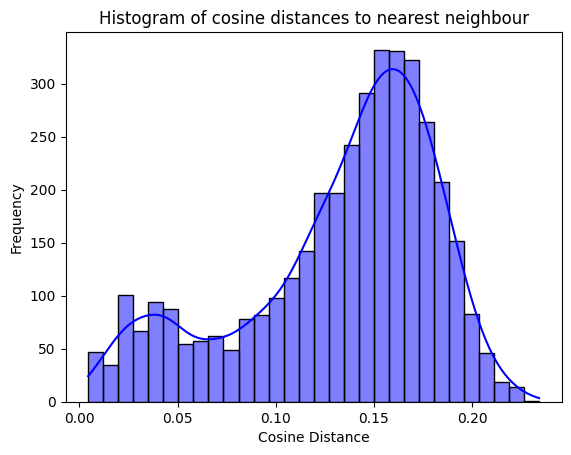

In [4]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(np.unique(dataset.x))

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [5]:
number_similar_sequences = np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

0 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


## Labels statistics

In [6]:
print(dataset.get_label_stats().to_dict())

{'nobs': {0: 3913}, 'minmax': {0: (0.0, 1.0)}, 'mean': {0: 0.7117991311014567}, 'variance': {0: 0.07347298929372334}, 'skewness': {0: -0.5204285185966728}, 'kurtosis': {0: -0.9369598597554303}, 'num_zeros': {0: 7}}


In [7]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

0 datapoints are identified as outliers by IQR method


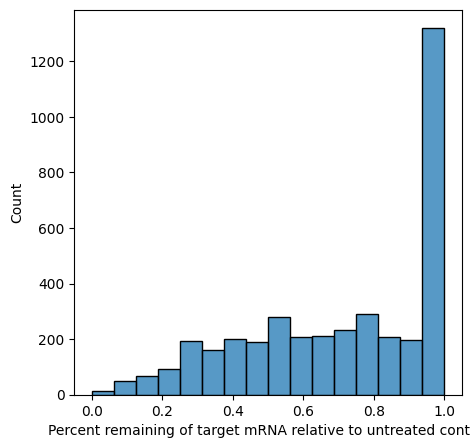

In [8]:
fig,ax=plt.subplots(figsize=[5,5])

sns.histplot(x=dataset.y)
ax.set_xlabel('Percent remaining of target mRNA relative to untreated control')
plt.show()

## Splitting analysis

In [9]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

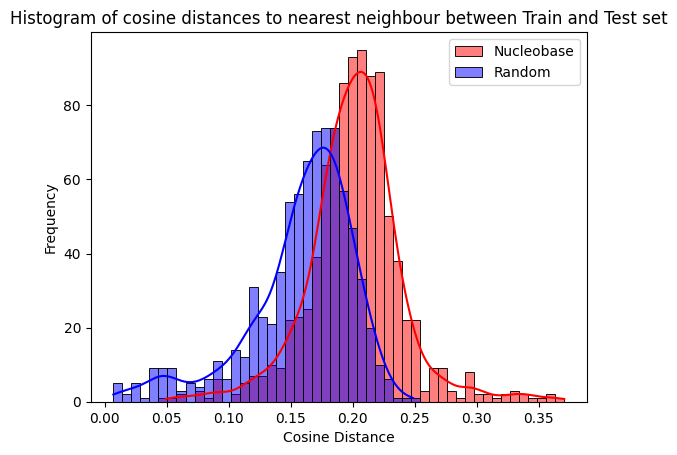

In [10]:
data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 50
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

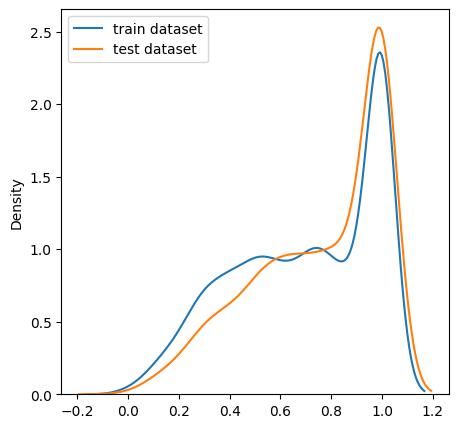

In [11]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.legend()
plt.show()

## Predictability analysis

In [12]:
x_train,x_test,y_train,y_test = dataset.split('nucleobase')
feat=KMersCounts(k=[1,2,3], modification_abundance=False)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=LinearModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

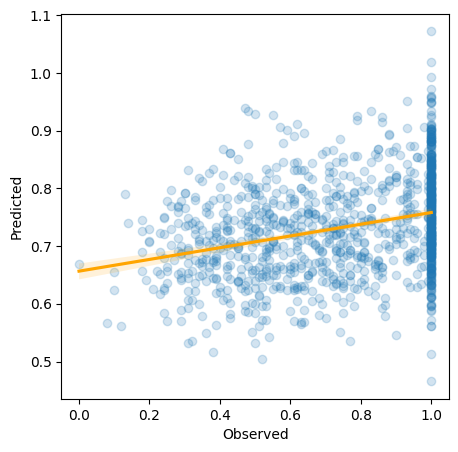

{'r2_score': 0.08488212764745173, 'root_mean_squared_error': 0.24130770132325813, 'mean_absolute_error': 0.2071035111860795, 'pearson_correlation': 0.2994248401527392, 'spearman_correlation': 0.29096394910750367}


In [13]:
fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))